###### Emotions dataset for NLP Classification
###### data source:https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

# import dataset

In [3]:
import zipfile

zip_ref=zipfile.ZipFile("/content/Emotions dataset for NLP.zip")
zip_ref.extractall("/content/Emotions_dataset")
zip_ref.close()

In [4]:
# from txtfile to list
with open("/content/Emotions_dataset/train.txt") as f:
  train=f.readlines()

In [ ]:
train[:2]

['i didnt feel humiliated;sadness\n',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake;sadness\n']

In [5]:
# split sentences and labels
sentences=[]
emotions=[]
ls=[]
sentences_lens=[]
for item in train:
    ls=item[:-1].split(";")
    sentences.append(ls[0])
    emotions.append(ls[1])
    sentences_lens.append(len(ls[0]))

In [7]:
# check how the distribution of classes
import pandas as pd
df=pd.Series(emotions)
counts=df.value_counts()
print(counts)

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


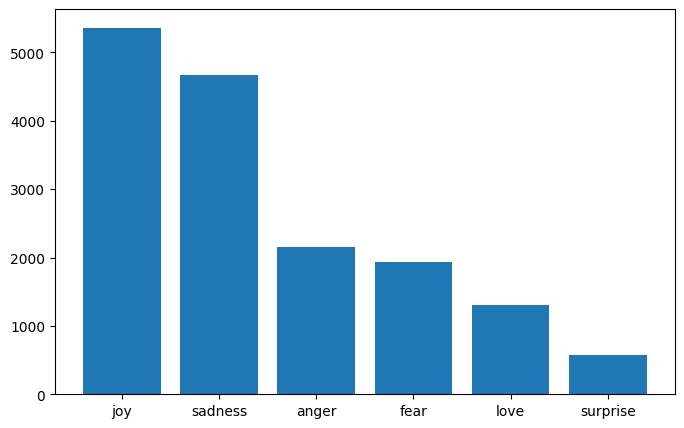

In [8]:
from matplotlib import pyplot as plt
x=counts.index
y=counts.values
plt.figure(figsize=(8,5))
plt.bar(x,y)
plt.show()

In [9]:
# check the lens of sentences

df=pd.Series(sentences_lens)
df.describe()

count    16000.000000
mean        96.845812
std         55.904953
min          7.000000
25%         53.000000
50%         86.000000
75%        129.000000
max        300.000000
dtype: float64

# define global  variate

In [37]:
class Global_Var:
  max_length=100
  embedding_dim=16

# Tokenizer the train dateset

In [38]:
# tokenizer the senctences

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length=100

tokenizer_sentences=Tokenizer(oov_token="<OOV>")
tokenizer_sentences.fit_on_texts(sentences)
sequences=tokenizer_sentences.texts_to_sequences(sentences)
X_train=pad_sequences(sequences,padding="post",maxlen=Global_Var.max_length,truncating="post")

In [11]:
word_index=tokenizer_sentences.word_index
print(f"numbers of words in word_index:{len(word_index)}")

numbers of words in word_index:15213


In [30]:
print(f"the original sentence:{sentences[0]}")
print(f"the tokenized sentence:{sequences[0]}")
print(f"the padded sentence:{X_train[0]}")

the original sentence:i didnt feel humiliated
the tokenized sentence:[2, 139, 3, 679]
the padded sentence:[  2 139   3 679   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


# Encoder the labels

In [14]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
encoder.fit(emotions)
print(f"classes:{encoder.classes_}")

classes:['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']


In [15]:
y_train=encoder.transform(emotions)

# prepare test and validation dataset

In [16]:
#define a funticon to read test and vailidation dataset
def txtfile_to_list(text_dir):
  with open(text_dir) as f:
    text=f.readlines()

  sentences=[]
  emotions=[]

  for item in text:
    ls=item[:-1].split(";")
    sentences.append(ls[0])
    emotions.append(ls[1])

  return sentences,emotions

In [39]:
# prepare test dataset
X,y=txtfile_to_list("/content/Emotions_dataset/test.txt")

X_test=tokenizer_sentences.texts_to_sequences(X)
X_test=pad_sequences(X_test,padding="post",maxlen=Global_Var.max_length,truncating="post")

y_test=encoder.transform(y)


In [41]:
print(f"X_val shape:{X_test.shape}\ny_val shape:{y_test.shape}")

X_val shape:(2000, 100)
y_val shape:(2000,)


In [43]:
# prepare validation dataset
X,y=txtfile_to_list("/content/Emotions_dataset/val.txt")

X_val=tokenizer_sentences.texts_to_sequences(X)
X_val=pad_sequences(X_val,padding="post",maxlen=Global_Var.max_length,truncating="post")

y_val=encoder.transform(y)


In [44]:
print(f"X_val shape:{X_val.shape}\ny_val shape:{y_val.shape}")

X_val shape:(2000, 100)
y_val shape:(2000,)


# Build a LSTM model

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

vocal_size=len(tokenizer_sentences.word_index)+1

In [24]:
#define a callback
class mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get("accuracy")>0.95:
      print("\nreached val_accuracy higher than 0.95,cancelling the process!")
      self.model.stop_training=True

mycallback=mycallback()

In [72]:
# define a LSTM model

def LSTM_model():
  model=Sequential()
  model.add(layers.Embedding(vocal_size,Global_Var.embedding_dim,input_length=Global_Var.max_length))
  #model.add(layers.Bidirectional(layers.LSTM(64,return_sequences=True)))
  model.add(layers.Bidirectional(layers.LSTM(32)))

  model.add(layers.Dense(128,activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(6,activation="softmax"))

  return model


In [73]:
LSTM_model=LSTM_model()
LSTM_model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
#LSTM_model.summary()

In [74]:
LSTM_history=LSTM_model.fit(X_train,y_train,epochs=8,batch_size=128,validation_data=(X_val,y_val),verbose=1,callbacks=[mycallback])

Epoch 1/8
125/125 [==============================] - 18s 119ms/step - loss: 1.6067 - accuracy: 0.3298 - val_loss: 1.5457 - val_accuracy: 0.4235
Epoch 2/8
125/125 [==============================] - 13s 104ms/step - loss: 1.1670 - accuracy: 0.5181 - val_loss: 0.8472 - val_accuracy: 0.6890
Epoch 3/8
125/125 [==============================] - 15s 116ms/step - loss: 0.6490 - accuracy: 0.7505 - val_loss: 0.6622 - val_accuracy: 0.7790
Epoch 4/8
125/125 [==============================] - 13s 105ms/step - loss: 0.4348 - accuracy: 0.8456 - val_loss: 0.6337 - val_accuracy: 0.8000
Epoch 5/8
125/125 [==============================] - 13s 102ms/step - loss: 0.3108 - accuracy: 0.9003 - val_loss: 0.6315 - val_accuracy: 0.8085
Epoch 6/8
125/125 [==============================] - 15s 117ms/step - loss: 0.2317 - accuracy: 0.9275 - val_loss: 0.6187 - val_accuracy: 0.8180
Epoch 7/8
125/125 [==============================] - 13s 105ms/step - loss: 0.1818 - accuracy: 0.9464 - val_loss: 0.6464 - val_accuracy:

In [25]:
import matplotlib.pyplot as plt

def plot_graphs(history,metric):
  epochs=range(1,len(history.history[metric])+1)
  plt.plot(epochs,history.history[metric])
  plt.plot(epochs,history.history["val_"+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric,"val_"+metric])
  plt.show()

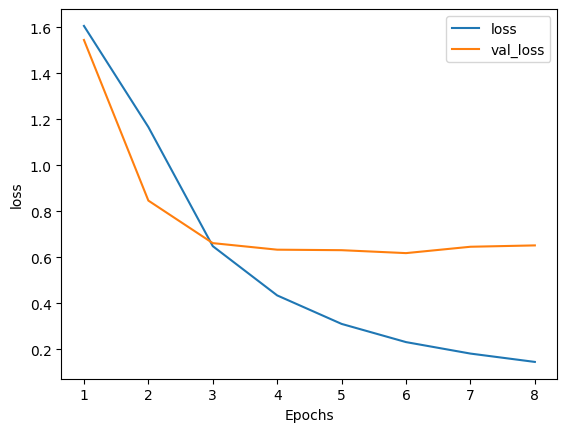

In [75]:
plot_graphs(LSTM_history,"loss")

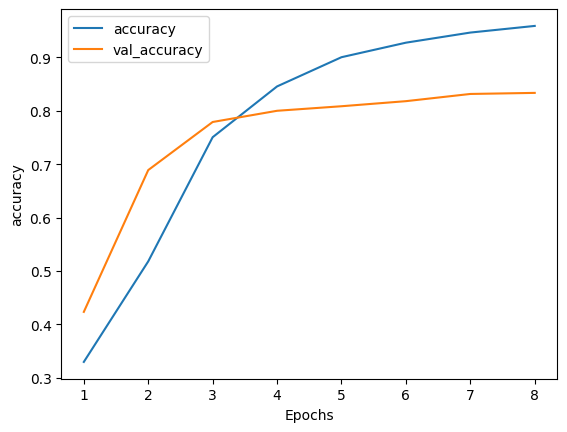

In [76]:
plot_graphs(LSTM_history,"accuracy")

# Build a CNN model

In [67]:
# define a LSTM model

def CNN_model():
  model=Sequential()
  model.add(layers.Embedding(vocal_size,Global_Var.embedding_dim,input_length=Global_Var.max_length))
  model.add(layers.Conv1D(filters=64,kernel_size=4,activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.GlobalMaxPooling1D())

  model.add(layers.Dense(64,activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(6,activation="softmax"))

  return model

In [68]:
CNN_model=CNN_model()
CNN_model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [69]:
CNN_history=CNN_model.fit(X_train,y_train,epochs=8,batch_size=128,validation_data=(X_val,y_val),verbose=1)

Epoch 1/8
125/125 [==============================] - 5s 29ms/step - loss: 1.6132 - accuracy: 0.3184 - val_loss: 1.6033 - val_accuracy: 0.3520
Epoch 2/8
125/125 [==============================] - 4s 29ms/step - loss: 1.2881 - accuracy: 0.5077 - val_loss: 0.9052 - val_accuracy: 0.6730
Epoch 3/8
125/125 [==============================] - 4s 34ms/step - loss: 0.7276 - accuracy: 0.7463 - val_loss: 0.6239 - val_accuracy: 0.8050
Epoch 4/8
125/125 [==============================] - 5s 36ms/step - loss: 0.4512 - accuracy: 0.8442 - val_loss: 0.4006 - val_accuracy: 0.8820
Epoch 5/8
125/125 [==============================] - 4s 29ms/step - loss: 0.2853 - accuracy: 0.9086 - val_loss: 0.3033 - val_accuracy: 0.9080
Epoch 6/8
125/125 [==============================] - 4s 29ms/step - loss: 0.2016 - accuracy: 0.9382 - val_loss: 0.2661 - val_accuracy: 0.9135
Epoch 7/8
125/125 [==============================] - 5s 41ms/step - loss: 0.1468 - accuracy: 0.9560 - val_loss: 0.2470 - val_accuracy: 0.9160
Epoch 

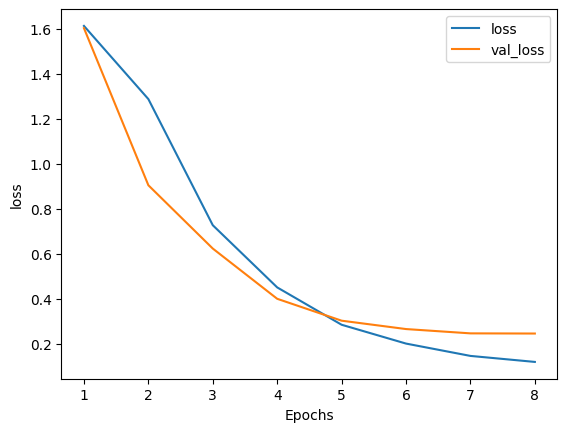

In [70]:
plot_graphs(CNN_history,"loss")

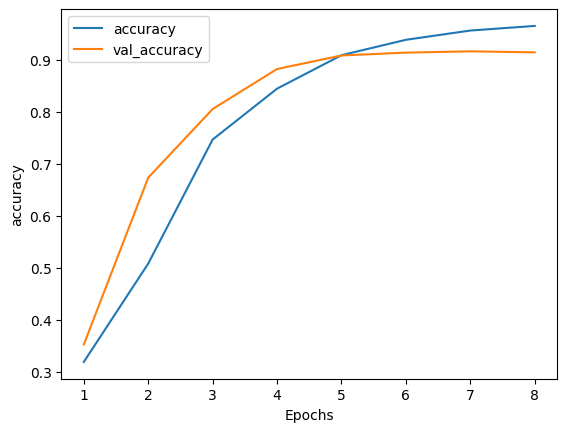

In [71]:
plot_graphs(CNN_history,"accuracy")

# Prediction

63/63 [==============================] - 0s 5ms/step
accuracy:0.909


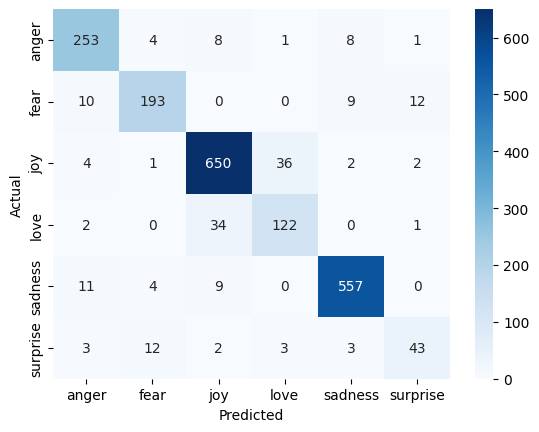

In [78]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import seaborn as sns
import numpy as np

y_pred=CNN_model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)

acc=accuracy_score(y_test,y_pred)
print(f"accuracy:{acc}")

cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#print(classification_report(y_test,y_pred))


In [79]:
CNN_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 16)           243424    
                                                                 
 conv1d_6 (Conv1D)           (None, 97, 64)            4160      
                                                                 
 dropout_12 (Dropout)        (None, 97, 64)            0         
                                                                 
 global_max_pooling1d_6 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                      